# `fmri-10`: Searchlight analysis
This demo introduces searchlight analysis using the familiar visual object recognition dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). The goal of searchlight analysis is to apply spatially localized multivariate pattern analysis (MVPA) throughout the brain ([Kriegeskorte et al., 2006](https://doi.org/10.1073/pnas.0600244103)). This brings us back to the question of *localization*, allowing us to "search" throughout the brain for local patterns of activity containing information about our experimental manipulation. In searchlight analysis, we apply MVPA within local neighborhoods of voxels—typically defined as a sphere or cube in volumetric space, or a disk in surface space. These local neighborhoods are iteratively centered at each voxel in the brain and the MVPA result for a given neighborhood is assigned to the center voxel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Visual object recognition dataset
We'll start demo-ing RSA with our familiar visual object recognition fMRI dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). Recall that participants were presented with images from 8 object categories (bottles, cats, chairs, faces, houses, scissors, scrambled images, and shoes) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. We'll focus on data from one subject for the purposes of this demo.

In [2]:
# Load the Haxby 2001 dataset
from nilearn import datasets
from nilearn.image import concat_imgs, index_img, mean_img, new_img_like
from nilearn.input_data import NiftiMasker

data_dir = '/jukebox/PNI-classes/students/NEU502/2021/nilearn-data'

#haxby_dataset = datasets.fetch_haxby()
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)
func_file = haxby_dataset.func[0]

Rather than focusing on ventral temporal (VT) cortex, we want to run the searchlight analysis throughout the whole brain. For this example, we'll use Nilearn's `NiftiMasker` to automatically generate a whole-brain mask based on the mean EPI image. (We use this approach because it yields a more conservative mask than the whole-brain mask provided with the dataset.)

In [3]:
# Use nilearn to automagically create an EPI brain mask
func_mean = mean_img(func_file)

masker = NiftiMasker(mask_strategy='epi').fit(func_mean)
mask = masker.mask_img_

### Runwise GLM
Prior to the upcoming searchlight analysis, we perform a first-level GLM to account for confounds and extract regression coefficients ("betas") corresponding to each stimulus category. For searchlight classification analysis, we'll perform separate GLMs for each scanning run (runwise GLM), yielding 8 betas corresponding to the 8 stimulus categories for each run. We perform a runwise GLM so that we can cross-validate across runs in the searchlight classification analysis.

In [4]:
# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Get list of unique stimulus categories (excluding rest)
categories = np.array([c for c in np.unique(stimuli) if c != 'rest'])

In [5]:
# Split functional image according to runs
func_runs = []
for run in np.unique(runs):
    func_runs.append(index_img(func_file, runs == run))
    print(f"Indexed run {run + 1} functional image")

Indexed run 1 functional image
Indexed run 2 functional image
Indexed run 3 functional image
Indexed run 4 functional image
Indexed run 5 functional image
Indexed run 6 functional image
Indexed run 7 functional image
Indexed run 8 functional image
Indexed run 9 functional image
Indexed run 10 functional image
Indexed run 11 functional image
Indexed run 12 functional image


In [6]:
# Build first-level GLM for each run
from nilearn.glm.first_level import (make_first_level_design_matrix,
                                     FirstLevelModel)

# Set parameters for your design matrix
tr = 2.5
hrf_model = 'spm'
drift_model = 'Cosine'
high_pass = 1/128

# Build a design matrix for each run
design_matrices = []
for run in np.unique(runs):
    stimuli_run = stimuli[runs == run]
    n_trs = len(stimuli_run)
    onsets = tr * np.arange(n_trs)
    duration = np.full(n_trs, tr)
    
    events_all = pd.DataFrame(
        {'onset': onsets, 'trial_type': stimuli_run, 'duration': duration})
    events = events_all[events_all['trial_type'] != 'rest']
    
    design_matrix = make_first_level_design_matrix(
        onsets,
        events,
        hrf_model=hrf_model,
        drift_model=drift_model,
        high_pass=high_pass)
    
    design_matrices.append(design_matrix)

/jukebox/hasson/snastase/miniconda3/envs/neu502b/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [7]:
# Fit runwise GLM separately for each runs
glm_rw = FirstLevelModel(t_r=tr,
                         mask_img=mask,
                         standardize=True,
                         noise_model='ar1')

maps_rw = []
categories_rw = []
runs_rw = []
for run, (func_run, design_matrix) in enumerate(zip(func_runs, design_matrices)):
    glm_rw.fit(func_run, design_matrices=design_matrix)

    # Collate contrast maps for VT
    for category in categories:
        maps_rw.append(glm_rw.compute_contrast(category))
        categories_rw.append(category)
        runs_rw.append(run)
        
    print(f"Finished fitting GLM for run {run + 1}")
    
# Concatenate images for separate runs
maps_rw = concat_imgs(maps_rw)

Finished fitting GLM for run 1
Finished fitting GLM for run 2
Finished fitting GLM for run 3
Finished fitting GLM for run 4
Finished fitting GLM for run 5
Finished fitting GLM for run 6
Finished fitting GLM for run 7
Finished fitting GLM for run 8
Finished fitting GLM for run 9
Finished fitting GLM for run 10
Finished fitting GLM for run 11
Finished fitting GLM for run 12


### Searchlight classification analysis
We now supply the whole-brain beta maps and accompanying category labels to a searchlight classification analysis. We first specify a very simple 3-fold cross-validation scheme to reduce computation time. We define our searchlight with a 5 mm radius (corresponding to two 2.5 mm voxels) and run the searchlight within the automated whole-brain mask. Within each searchlight, we'll deploy a support vector machine (SVM) classifier with default parameters using Nilearn's `'svc'` shortcut. (Note that this will take several minutes to run!)

In [8]:
# Set up simple cross-validation scheme
from sklearn.model_selection import KFold
cv = KFold(n_splits=3)

# Set up searchlight parameters
from nilearn.decoding import SearchLight

n_jobs = 8
radius = 5.0
searchlight = SearchLight(mask,
                          process_mask_img=mask,
                          radius=radius,
                          estimator='svc',
                          n_jobs=n_jobs,
                          verbose=1, cv=cv)

# Fit the searchlight (this takes time!)
searchlight.fit(maps_rw, categories_rw)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.1min finished


SearchLight(cv=KFold(n_splits=3, random_state=None, shuffle=False),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fd32c14a910>,
            n_jobs=8,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fd32c14a910>,
            radius=5.0, verbose=1)

In [9]:
# Convert searchlight output to NIfTI image and save
import nibabel as nib

searchlight_img = new_img_like(func_mean, searchlight.scores_)
nib.save(searchlight_img, 'haxby_searchlight_svc.nii.gz')

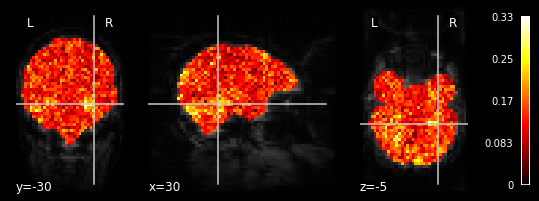

In [10]:
# Plot searchlight classification
from nilearn.plotting import plot_stat_map

cut_coords = (30, -30, -5)

plot_stat_map(searchlight_img, func_mean,
              cut_coords=cut_coords);

In [11]:
# Get coordinate of best-performing searchlight
max_sl = np.unravel_index(np.argmax(searchlight_img.get_fdata()),
                          searchlight_img.shape)

print("Best searchlight accuracy: "
      f"{searchlight_img.get_fdata()[max_sl]:.3f}")

Best searchlight accuracy: 0.333


#### References
* Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, *293*(5539), 2425–2430. https://doi.org/10.1126/science.1063736

* Kriegeskorte, N., Goebel, R., & Bandettini, P. (2006). Information-based functional brain mapping. *Proceedings of the National Academy of Sciences of the United States of America*, *103*(10), 3863-3868. https://doi.org/10.1073/pnas.0600244103